# Optimizing Posterior Covariance using Time Warping

One of the issues learning maneuvers is determining which datasets are likely to be similiar to each other. Logically you would expect that maneuvers performed at different speeds would be similiar. However because the the frequency shift, standard mutual information measurements will give will show that the two maneuvers are seperate and unique with little to no information shown between them. One of the things to see is if there is some time warping that could be applied to the two different speed tests such that they would show that they do share a lot of mutual information if they represent the same maneuver.

## Small Scale Demo

Before dealing with large datasets, it would be preferable on demonstrate this on some toy time series.

In [1]:
from thesis.data import blackbird_dataset as rbd
from thesis.models import train_optimal_controller as toc
import time
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import *

%matplotlib notebook

### Phase shift

Will same signal but shifted in time reduce the posterior covariance? For this we will have the two bivariate time series $X(t) = \lbrace \cos\left(2\pi f_1 t\right) , \sin\left(2\pi f_1 t\right) \rbrace$ and then $Y(g) = \lbrace \cos\left(2\pi f_1 t - \pi/4\right) , \sin\left(2\pi f_1 t - \pi/4\right) \rbrace $

In [2]:
# Setting up the two frequencies
f1 = 10.
f2 = 3.

# Let t1 be the index of a time series and Xt(t1) be the bivariate {cos(2pi*f*t), sin(2pi*f*t)}
t1 = np.linspace(0, 1, 101)  # N samples
X = np.zeros(t1.shape + (2,))  # N x 2 samples
X[:,0] = np.cos(2.*np.pi*f1*t1)  # 10 Hz
X[:,1] = np.sin(2.*np.pi*f1*t1)  # 10 Hz

# By construction we know Xt is zero mean
Sxx = (X.T @ X)/(t1.shape[0] - 1)  # The Covariance matrix

print("Covariance of X(t)={cos(2pi*%f*t), sin(2pi*%f*t)}:" % (f1,f1))
print(Sxx)

# Now let Yt be the sa that is Xt but lagged a quater cycle
t2 = t1
Y = np.zeros(X.shape)
Y[:, 1] = np.cos(2.*np.pi*f1*t2 - np.pi/4)
Y[:, 0] = np.sin(2.*np.pi*f1*t2 - np.pi/4)

# Find covariance of Y, note it is zero mean
Syy = (Y.T @ Y)/(t2.shape[0] - 1)

print("Covariance of Y(t)={cos(2pi*%f*t - pi/4), sin(2pi*%f*t - pi/4)}:" % (f1,f1))
print(Syy)

# Find the cross covariance as well as as posterior variance
Sxy = (X.T @ Y)/(t1.shape[0] - 1)

print("Cov(X,Y):")
print(Sxy)

print("Sigma_X|Y:")
print(Sxx - (Sxy @ np.linalg.inv(Syy) @ Sxy.T))  # Nearly zero i.e. almost recovered perfectly

Covariance of X(t)={cos(2pi*10.000000*t), sin(2pi*10.000000*t)}:
[[ 5.10000000e-01 -1.58038741e-17]
 [-1.58038741e-17  5.00000000e-01]]
Covariance of Y(t)={cos(2pi*10.000000*t - pi/4), sin(2pi*10.000000*t - pi/4)}:
[[ 0.505 -0.005]
 [-0.005  0.505]]
Cov(X,Y):
[[-0.36062446  0.36062446]
 [ 0.35355339  0.35355339]]
Sigma_X|Y:
[[ 2.22044605e-16  2.18048631e-16]
 [ 1.67637752e-16 -2.77555756e-16]]


Since the posterior covariance matrix is essentially zero, we can say that the two time series share mutual information.

### Frequency Shift

Doing the same thing but this time we will have the $Y(t) = \lbrace \cos\left(2\pi f_2 t\right) , \sin\left(2\pi f_2 t\right) \rbrace$ be of a different frequency but not phase shifted.

In [3]:
# Now let Yt have a different frequency to Xt
Y[:, 0] = np.cos(2.*np.pi*f2*t2)
Y[:, 1] = np.sin(2.*np.pi*f2*t2)

# Find covariance of Y, note it is zero mean
Syy = (Y.T @ Y)/(t2.shape[0] - 1)

print("\nCovariance of Y(t)={cos(2pi*%f*t), sin(2pi*%f*t)}:" % (f2,f2))
print(Syy)

# Find the cross covariance as well as as posterior variance
Sxy = (X.T @ Y)/(t1.shape[0] - 1)

print("Cov(X,Y):")  # With the time scaling, Cov(X,Y) appears nearly uncorrelated
print(Sxy)

print("Sigma_X|Y:")
print(Sxx - (Sxy @ np.linalg.inv(Syy) @ Sxy.T))  # Essentially the same as prior covariance


Covariance of Y(t)={cos(2pi*3.000000*t), sin(2pi*3.000000*t)}:
[[5.10000000e-01 5.47863533e-17]
 [5.47863533e-17 5.00000000e-01]]
Cov(X,Y):
[[ 1.00000000e-02  1.52496072e-16]
 [-1.66960120e-16  2.20517886e-16]]
Sigma_X|Y:
[[ 5.09803922e-01 -1.25301463e-17]
 [-1.25301463e-17  5.00000000e-01]]


As the posterior covariance is essentially the prior covariance, the mutual information will show no information is shared between $X$ and $Y$ even though they are the same but frequency shifted.

### Optimization on time warping

With showing that frequency shifted series with no time warping will give an estimate of no mutual information, we will now try to write an objective function that will find an optimum scaling and shift on the time series. As we only have discrete points, we need an interpolation function to estimate the cross covariance by temporially aligning the two series.

In [4]:
# Make interpolation function for timescaling
def interp_param_space(x, xg, fxg):
    """Linear interpolation of function f:R -> (R/C)^n based on order given samples of xg"""
    assert len(xg.shape) == 1
    assert len(fxg.shape) > 0
    if x <= xg[0]:
        return fxg[0]
    elif x > xg[-1]:
        return fxg[-1]
    else:
        i = np.arange(xg.shape[0])[xg < x][-1]  # Lower index for linear interpolation
        w = xg[i+1] - xg[i]
        return (xg[i+1] - x)/w*fxg[i] + (x - xg[i])/w*fxg[i+1]

vec_interp_param_space = np.vectorize(
    interp_param_space,
    signature='(),(m),(m,k)->(k)'  # Signature of the function being vectorized
)

With an interpolation for the cross series covariance matrix, we write an objective function that will warp two time series before finding the cross series covariance matrix to calculate the posterior covariance matrix of one variable. The objective is to minimize the squared of the Frobenious norm of the posterior covariance matrix. The first objective function `objective1` will always warp the `B` to `A` when considering the cross series covariance.

Objective function without shifting or scaling:
0.5099000384467514
Objective function correctly scaled (0.300000) but not intersecting time:
0.41888710842241694


<IPython.core.display.Javascript object>


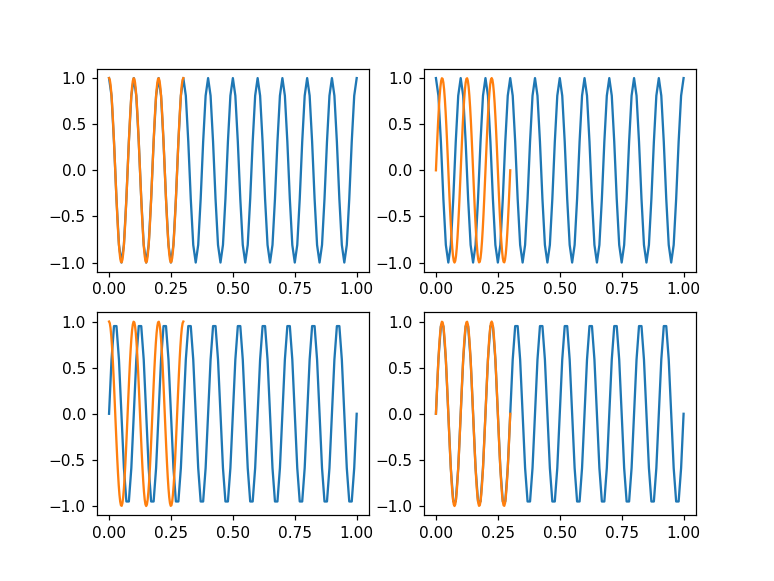

In [5]:
# Create objective function
def objective1(x, ta, A, Saa, tb, B, Sbb):
    """ Minimizing the squared Frobenius norm of the posterior covariance of Saa
    
    Args:
        x (float, float): (shift, scale)
                        : shift = bias applied to ta
                        : scale = scaling applied to tb
        tc (np.ndarray): (N,) array of time index for time series C
        C (np.ndarray): (N,k) time series of N observations with k variables
        Scc (np.ndarray): (k,k) covariance matrix of series C

    """

    # Get shitft and scale
    shift = x[0]
    scale = x[1]
    
    B_time_warped = vec_interp_param_space(ta + shift, tb*scale, B)

    Sab = (A.T @ B_time_warped)/(ta.shape[0] - 1)
    Saa_post = Saa - (Sab @ np.linalg.inv(Sbb) @ Sab.T)

    return np.sum(Saa_post ** 2)

# Show example of it not optimized
print("Objective function without shifting or scaling:")
print(objective1(np.array([0,0]), t1, X, Sxx, t2, Y, Syy))

print("Objective function correctly scaled (%f) but not intersecting time:" % (f2/f1))
print(objective1(np.array([0,f2/f1]), t1, X, Sxx, t2, Y, Syy))

fig, ax = plt.subplots(2,2)

ax[0,0].plot(t1, X[:,0])
ax[0,0].plot(t2 * f2/f1, Y[:,0])

ax[1,0].plot(t1, X[:,1])
ax[1,0].plot(t2 * f2/f1, Y[:,0])

ax[0,1].plot(t1, X[:,0])
ax[0,1].plot(t2 * f2/f1, Y[:,1])

ax[1,1].plot(t1, X[:,1])
ax[1,1].plot(t2 * f2/f1, Y[:,1])

plt.show()

While the above graph looks promising in terms of matching, the objective function is showing a fairly poor result. This is due to how the interpolation works. Since we calculate `B` warped to `A`'s time the interval $[1/3, 1]$ is being all `B[-1]` as this is beyond the maximum time reported in `tb`.  A different approach is that we always warp the larger time interval after scaling to the smaller time interval. If `ta` is in $[0, 1]$ while `tb` after scaling is on $[0, \beta]$ then we use `tb` for calculating the cross covariance if $\beta < 1$ and `ta` otherwise.

Objective function correctly scaled (0.300000) and time based on smaller interval:
0.0020020102896609097


<IPython.core.display.Javascript object>


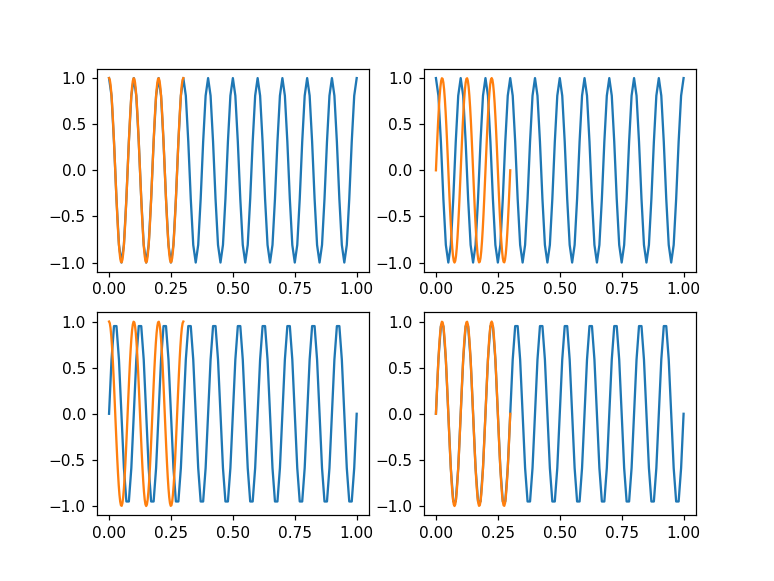

In [6]:
# Another objective function but using the shorter interval for warping
def objective2(x, ta, A, Saa, tb, B, Sbb):
    """ Minimizing the squared Frobenius norm of the posterior covariance of Saa
    
    Args:
        x (float, float): (shift, scale)
                        : shift = bias applied to ta
                        ; scale = scaling applied to tb

    """

    # Get shitft and scale
    shift = x[0]
    scale = x[1]
    
    if scale > 1:
        # Case when B has been lengthened i.e. slowed down
        A_time_warped = A  # A searches inside of B
        B_time_warped = vec_interp_param_space(ta + shift, tb*scale, B)
        N = ta.shape[0]
    else:
        # Case when B is now shorter i.e. speed up but slower interval
        A_time_warped = vec_interp_param_space(tb*scale, ta + shift, A)
        B_time_warped = B
        N = tb.shape[0]
        
    Sab = (A_time_warped.T @ B_time_warped)/(N - 1)
    Saa_post = Saa - (Sab @ np.linalg.inv(Sbb) @ Sab.T)

    return np.sum(Saa_post ** 2)

print("Objective function correctly scaled (%f) and time based on smaller interval:" % (f2/f1))
print(objective2(np.array([0, f2/f1]), t1, X, Sxx, t2, Y, Syy))

fig, ax = plt.subplots(2,2)

ax[0,0].plot(t1, X[:,0])
ax[0,0].plot(t2 * f2/f1, Y[:,0])

ax[1,0].plot(t1, X[:,1])
ax[1,0].plot(t2 * f2/f1, Y[:,0])

ax[0,1].plot(t1, X[:,0])
ax[0,1].plot(t2 * f2/f1, Y[:,1])

ax[1,1].plot(t1, X[:,1])
ax[1,1].plot(t2 * f2/f1, Y[:,1])

plt.show()

The objective function is now very close 0 so this is a better way to go.

### Optimization

Trying some optimizers to get this going, the local minimizers seem to have too much but the global optimizer seems to have good success.

C:\Users\Patrick\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Optimizer results:
           constr: [array([0., 0., 0.])]
 constr_violation: 0.0
              fun: 0.5082078356395732
            maxcv: 0.0
          message: 'Optimization terminated successfully.'
             nfev: 1638
              nit: 6
          success: True
                x: array([3.58769809, 6.15027703])


<IPython.core.display.Javascript object>


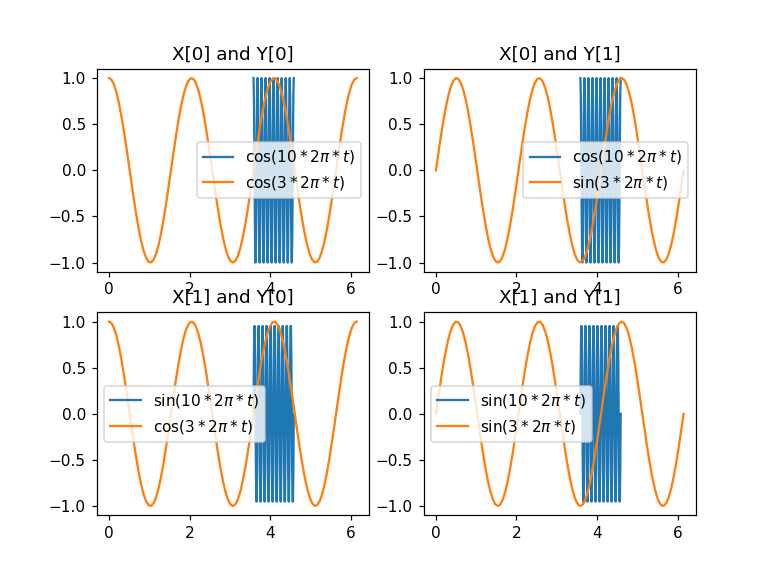

In [7]:
# x0 = [shift, scale] -> [a, b]
x0 = np.array([0, 1.5])
A = np.array(
    [[ 0, 1],  # Positive time scaling
     [-1, 1],  # a <= b i.e. one overlap condition
     [ 1, 0]]  # a + 1 >= 0 i.e. other overlap condition
)
lb = np.array([0, 0, -1])
ub = np.array([np.inf, np.inf, np.inf])
constraint = LinearConstraint(A, lb, ub, keep_feasible=True)

""" local optimizer setup
res = minimize(
    objective2, x0,
    (t1, X, Sxx, t2, Y, Syy),
    method='BFGS',
    jac='3-point',
    constraints=constraint,
    options={
        'disp': True
    }
)
"""

res = differential_evolution(
    func=objective2,
    bounds=[(-10, 10), (1e-2, 10)],
    args=(t1, X, Sxx, t2, Y, Syy),
    constraints=constraint
)

print("Optimizer results:")
print(res)

shift = res.x[0]
scale = res.x[1]

fig, ax = plt.subplots(2,2)

for i in range(2):
    for j in range(2):
        # Plot X[:, i] with shift
        ax[i,j].plot(
            t1 + shift,
            X[:,i],
            label=(
                r'$' +
                ('\cos' if i == 0 else '\sin') +
                '(%.0f*2\pi*t)$' % f1
            )
        )
        # Plot Y[:, i] with scaling
        ax[i,j].plot(
            t2*scale,
            Y[:,j],
            label=(
                '$' +
                ('\cos' if j == 0 else '\sin') +
                '(%.0f*2\pi*t)$' % f2
            )
        )
        ax[i,j].legend()
        ax[i,j].set_title('X[%i] and Y[%i]' % (i,j))

plt.show()

## Blackbird Dataset Test

Testing this out on the blackbird Dataset. Reading in the two datasets of the same maneuver but at different test speeds.

In [8]:
ft1 = ('figure8', 'Constant', 0.5)
ft2 = ('figure8', 'Constant', 1.)

In [9]:
test_df = rbd.cleaned_blackbird_test(*ft1)

X1, Y1, t1, info1 = rbd.generate_opt_control_test_data(
    test_df,
    past_delta_t=1.,  # 1 second past window
    future_delta_t=1.,  # 1 second future window
    downsample_dict=toc.DEFAULT_DOWNSAMPLING_DICT
)

del test_df

In [10]:
print(X1.shape, Y1.shape)
print(t1[-1,0] - t1[0,0])

(38089, 240) (38089, 40)
203.851257


In [11]:
test_df = rbd.cleaned_blackbird_test(*ft2)

X2, Y2, t2, info2 = rbd.generate_opt_control_test_data(
    test_df,
    past_delta_t=1.,  # 1 second past window
    future_delta_t=1.,  # 1 second future window
    downsample_dict=toc.DEFAULT_DOWNSAMPLING_DICT
)

del test_df

In [12]:
print(X2.shape, Y2.shape)
print(t2[-1,0] - t2[0,0])

(26352, 240) (26352, 40)
141.297054


In [13]:
# Removing the mean from the two datasets
X1 = X1 - np.mean(X1, axis=0)
X2 = X2 - np.mean(X2, axis=0)
Y1 = Y1 - np.mean(Y1, axis=0)
Y2 = Y2 - np.mean(Y2, axis=0)

In [14]:
# Calculating Covariances
Sxx_1 = (X1.T @ X1)/(t1.shape[0] - 1)
Syy_1 = (Y1.T @ Y1)/(t1.shape[0] - 1)
Sxx_2 = (X2.T @ X2)/(t2.shape[0] - 1)
Syy_2 = (Y2.T @ Y2)/(t2.shape[0] - 1)

In [15]:
# Rescaling time intervals
t1 = t1[:,0]
t1 = t1 - np.min(t1)
t1 = t1/np.max(t1)

t2 = t2[:,0]
t2 = t2 - np.min(t2)
t2 = t2/np.max(t2)

In [16]:
# Showing a default cost function
print("Original objective function: %f" % objective2(np.array([0, 1]), t1, Y1, Syy_1, t2, Y2, Syy_2))

Original objective function: 0.000016


In [17]:
start_time = time.time()

res = differential_evolution(
    func=objective2,
    bounds=[(-10, 10), (1e-2, 10)],
    args=(t1, Y1, Syy_1, t2, Y2, Syy_2),
    disp=True,
    constraints=constraint
)

stop_time = time.time()

print("Optimizer results:")
print(res)

differential_evolution step 1: f(x)= 6.39606e-06
differential_evolution step 2: f(x)= 6.39606e-06
differential_evolution step 3: f(x)= 2.33471e-06
differential_evolution step 4: f(x)= 2.33471e-06
differential_evolution step 5: f(x)= 1.29847e-06
differential_evolution step 6: f(x)= 8.30823e-07
differential_evolution step 7: f(x)= 8.30823e-07
differential_evolution step 8: f(x)= 8.30823e-07
differential_evolution step 9: f(x)= 8.30823e-07
differential_evolution step 10: f(x)= 8.30823e-07
differential_evolution step 11: f(x)= 8.30823e-07
differential_evolution step 12: f(x)= 8.30823e-07
differential_evolution step 13: f(x)= 8.30823e-07
differential_evolution step 14: f(x)= 8.30823e-07
differential_evolution step 15: f(x)= 8.30823e-07
differential_evolution step 16: f(x)= 7.91704e-07
differential_evolution step 17: f(x)= 7.91704e-07
differential_evolution step 18: f(x)= 7.91704e-07
differential_evolution step 19: f(x)= 6.2442e-07
differential_evolution step 20: f(x)= 6.2442e-07
differentia

In [18]:
print("Time for optimization: %f" % (stop_time - start_time))

Time for optimization: 2605.020238


<IPython.core.display.Javascript object>


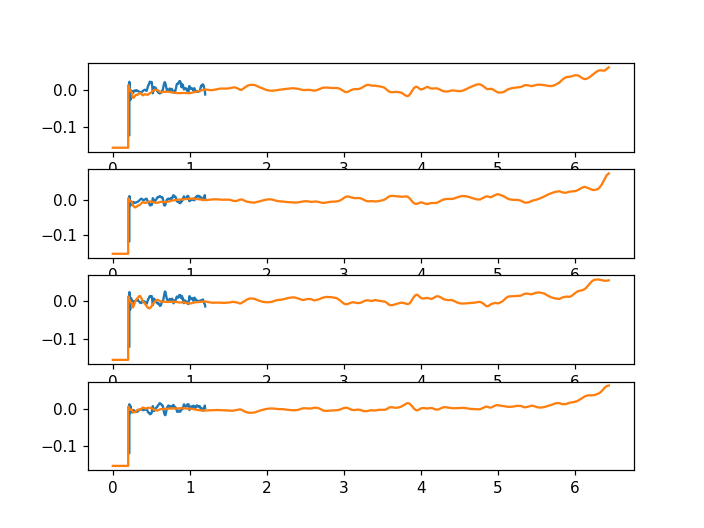

In [19]:
shift = res.x[0]
scaling = res.x[1]

fig, ax = plt.subplots(4,1)

for i in range(4):
    ax[i].plot(t1 + shift, Y1[:,i*10])
    ax[i].plot(t2*scaling, Y2[:,i*10])

plt.show()